In [1]:
import rosbag
import torch
import numpy as np
import pandas as pd
import rospy
import cv2
import os

PATH = r"/media/justin/New Volume/plain_rec_contents/rec_with_other_vehicles"

In [2]:
def clear(folder_path):
    # Iterate over the files and folders in the given folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path):
                # Delete the file
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                # Delete the folder and its contents recursively
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

In [3]:
def quaternion_to_euler_angle( w, x, y, z):
    ysqr = y * y

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    X = np.degrees(np.arctan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)
    t2 = np.where(t2>+1.0,+1.0,t2)
    #t2 = +1.0 if t2 > +1.0 else t2

    t2 = np.where(t2<-1.0, -1.0, t2)
    #t2 = -1.0 if t2 < -1.0 else t2
    Y = np.degrees(np.arcsin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = np.degrees(np.arctan2(t3, t4))

    return X, Y, Z 

def msg_extract(msg):
    X,Y,Z = quaternion_to_euler_angle( msg.orientation.w, msg.orientation.x, msg.orientation.y, msg.orientation.z)
    return {'velocity' : msg.velocity,
            'lin_acc_x' : msg.acceleration.linear.x,
            'lin_acc_y' : msg.acceleration.linear.y,
            'lin_acc_z' : msg.acceleration.linear.z,
            'ang_acc_x' : msg.acceleration.angular.x,
            'ang_acc_y' : msg.acceleration.angular.y,
            'ang_acc_z' : msg.acceleration.angular.z,
            'orient_x' : X,
            'orient_y' : Y,
            'orient_z' : Z,
            'throttle' : msg.control.throttle,
            'steer' : msg.control.steer,
            'brake' : msg.control.brake}

In [13]:
bag.get_type_and_topic_info().topics

{'/carla/ego_vehicle/rgb_front/image': TopicTuple(msg_type='sensor_msgs/Image', message_count=36001, connections=1, frequency=19.999999600022427),
 '/carla/ego_vehicle/vehicle_status': TopicTuple(msg_type='carla_msgs/CarlaEgoVehicleStatus', message_count=36000, connections=1, frequency=19.999999600022427)}

In [17]:
# Open the bag file
bag_file = r'/media/justin/New Volume/rosbags/rec_with_other_vehicles.bag'
bag = rosbag.Bag(bag_file)

topic1_name = '/carla/ego_vehicle/vehicle_status'
topic2_name = '/carla/ego_vehicle/rgb_front/image'

data = []
img_dir_path = os.path.join(PATH,'Images')
clear(img_dir_path)
temp = {}
prev_time = 266.48249408
for idx,(topic, msg, t) in enumerate(bag.read_messages(topics=[topic1_name,topic2_name])):
    # Process the message
    print(f"Received message on topic '{topic}' at time {t.to_sec()}:")
    
    # All the main filterations will happen in the kinematic section 
    # The images are chosen w.r.t the kinematic via prev_time and t.to_sec()
    if topic == topic1_name:
        check_msg = msg_extract(msg)
        if not (check_msg['throttle'] == 0 and check_msg['brake'] == 1 and check_msg['velocity'] < 0.1):
            temp = msg_extract(msg)
            temp_msg = msg       #just to check
            prev_time = t.to_sec()
        
    #print("See : ",topic,topic2_name,topic==topic2_name,prev_time,t.to_sec(),prev_time == t.to_sec())
    if topic == topic2_name and prev_time == t.to_sec():
        frame = np.frombuffer(msg.data, dtype=np.uint8).reshape((msg.height, msg.width, -1))
        filename = str(t.to_sec()) + '.png'
        filepath = os.path.join(img_dir_path,filename)
        if filename not in temp:
            cv2.imwrite(filepath,frame)
            temp['pic_file_name'] = filename
            cols = temp.keys()
        
    #print(len(temp)== 11,temp)
    if len(temp) == 14:
        data.append(temp)
        temp = {}

data = pd.DataFrame(data,columns = cols)
data

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 983.759978765:
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 983.759978765:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 983.759978765:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 983.809978766:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 983.809978766:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 983.859978767:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 983.859978767:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 983.909978767:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 983.909978767:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 983.959978768:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 983.959978768:
No
Received message on topic '/carla/ego_vehicl

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 986.209978802:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 986.209978802:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 986.259978802:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 986.259978802:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 986.309978803:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 986.309978803:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 986.359978804:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 986.359978804:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 986.409978805:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 986.409978805:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 986.459978805:
Received message on topic '/carla/ego_vehicl

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 988.709978839:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 988.709978839:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 988.75997884:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 988.75997884:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 988.80997884:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 988.80997884:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 988.859978841:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 988.859978841:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 988.909978842:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 988.909978842:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 988.959978843:
Received message on topic '/carla/ego_vehic

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 991.209978876:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 991.209978876:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 991.259978877:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 991.259978877:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 991.309978878:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 991.309978878:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 991.359978878:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 991.359978878:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 991.409978879:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 991.409978879:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 991.45997888:
Received message on topic '/carla/ego_ve

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 993.709978913:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 993.709978913:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 993.759978914:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 993.759978914:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 993.809978915:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 993.809978915:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 993.859978916:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 993.859978916:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 993.909978916:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 993.909978916:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 993.959978917:
Received message on topic '/carla/ego_v

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 996.209978951:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 996.209978951:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 996.259978951:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 996.259978951:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 996.309978952:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 996.309978952:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 996.359978953:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 996.359978953:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 996.409978954:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 996.409978954:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 996.459978954:
Received message on topic '/carla/ego_vehicl

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 998.709978988:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 998.709978988:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 998.759978989:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 998.759978989:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 998.809978989:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 998.809978989:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 998.85997899:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 998.85997899:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 998.909978991:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 998.909978991:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 998.959978992:
Received message on topic '/carla/ego_vehicle/

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1004.20997907:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1004.20997907:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1004.259979071:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1004.259979071:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1004.309979071:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1004.309979071:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1004.359979072:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1004.359979072:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1004.409979073:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1004.409979073:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1004.459979074:
Received message on topic '/carla/e

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1007.959979126:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1007.959979126:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1008.009979126:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1008.009979126:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1008.059979127:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1008.059979127:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1008.109979128:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1008.109979128:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1008.159979129:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1008.159979129:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1008.209979129:
Received message on topic '/carla

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1010.90997917:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1010.90997917:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1010.95997917:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1010.95997917:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1011.009979171:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1011.009979171:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1011.059979172:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1011.059979172:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1011.109979173:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1011.109979173:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1011.159979173:
Received message on topic '/carla/ego

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1015.159979233:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1015.159979233:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1015.209979234:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1015.209979234:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1015.259979235:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1015.259979235:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1015.309979235:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1015.309979235:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1015.359979236:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1015.359979236:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1015.409979237:
Received message on topic '/carla

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1020.159979308:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1020.159979308:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1020.209979308:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1020.209979308:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1020.259979309:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1020.259979309:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1020.30997931:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1020.30997931:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1020.359979311:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1020.359979311:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1020.409979311:
Received message on topic '/carla/e

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1024.35997937:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1024.35997937:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1024.409979371:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1024.409979371:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1024.459979372:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1024.459979372:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1024.509979372:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1024.509979372:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1024.559979373:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1024.559979373:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1024.609979374:
Received message on topic '/carla/e

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1026.909979408:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1026.909979408:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1026.959979409:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1026.959979409:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1027.00997941:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1027.00997941:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1027.05997941:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1027.05997941:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1027.109979411:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1027.109979411:
No
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1027.159979412:
Received message on topic '/carla/ego

Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1029.359979445:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1029.359979445:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1029.409979445:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1029.409979445:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1029.459979446:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1029.459979446:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1029.509979447:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1029.509979447:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1029.559979448:
Received message on topic '/carla/ego_vehicle/vehicle_status' at time 1029.559979448:
Yes
Received message on topic '/carla/ego_vehicle/rgb_front/image' at time 1029.609979448:
Received message on topic '/

KeyboardInterrupt: 

In [ ]:
data.to_csv(os.path.join(PATH,'data.csv'))

# Verification

In [ ]:
class plotter:
    def __init__(self,origin = (50,100)):
        
        self.axis_length = 100
        self.origin = origin
        self.track = [0]*self.axis_length*2
    
    def plot(self,frame,tag,idx):
        
        value = data[tag][idx]/(data[tag].max() - data[tag].min())
        value = -int(value*self.axis_length)
        self.track.pop(0)
        self.track.append(value)
        
        origin = self.origin
        axis_length = self.axis_length
        
        for x_offset,val in enumerate(self.track):
            color = (0,255,0)
            radius = 1
            center = (origin[0]+x_offset,int(origin[1]+val))
            frame = cv2.circle(frame, center, radius, color, -1)
            
        #Plot axis
        frame = cv2.line(frame, (origin[0], origin[1]), (origin[0] + 2*axis_length, origin[1]), (255, 255, 255), 1)
        frame = cv2.line(frame, (origin[0], origin[1] - axis_length), (origin[0], origin[1] + axis_length), (255, 255, 255),1)
        
        org = (origin[0],origin[1]-int(self.axis_length/2))
        frame = cv2.putText(frame, tag + ' : '+ f"{data[tag][idx]:.4f}", org, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), thickness=2, lineType=cv2.LINE_8)
        
        return frame

In [ ]:
data

In [ ]:
frame_modifier1 = plotter(origin=(50,640-100))
frame_modifier2 = plotter(origin=(50,640-200))

kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

video_flg = 1
if video_flg:
    # Define the codec for the output video file
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video_name = os.path.join(PATH,"video-verification.avi")
    # Create the video writer object
    video = cv2.VideoWriter(video_name, fourcc, 60.0, (800,600))

for i in range(len(data)):
    temp_data = data.iloc[i]
    
    filename = temp_data['pic_file_name']
    filepath = os.path.join(img_dir_path,filename)
    
    print(filepath)
    frame = cv2.imread(filepath)
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #frame = cv2.filter2D(frame, -1, kernel)
    #frame = cv2.Laplacian(frame, cv2.CV_64F)

    # Convert the output to uint8
    #frame = np.uint8(np.absolute(frame))
    
    frame = cv2.putText(frame, "Frame no. : " + str(i), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
    
    if video_flg:
        frame = cv2.putText(frame, "Turn : " + data.iloc[i]['Turn_signal'], (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
        frame = cv2.putText(frame, "Turning : " + str(data.iloc[i]['Turning']), (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
        frame = cv2.putText(frame, "Traffic : " + str(data.iloc[i]['Traffic']), (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
    
    frame = frame_modifier1.plot(frame,'velocity',i)
    frame = frame_modifier2.plot(frame,'steer',i)
    cv2.imshow("Frame",frame)
    if video_flg:
        video.write(frame)
    
    # Check for key press to exit
    if (cv2.waitKey(1) & 0xFF == ord('q')) or i == len(data)-1:
        break
    

cv2.destroyAllWindows()
if video_flg:
    video.release()

<Axes: >

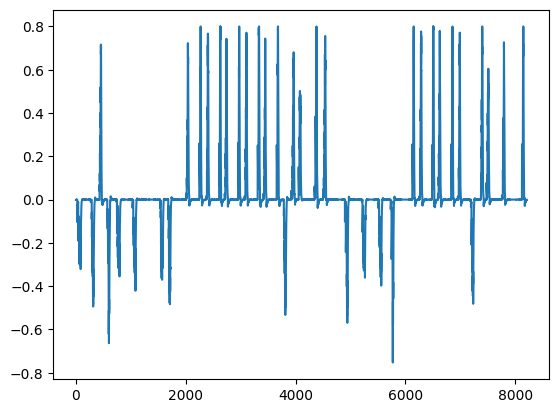

In [13]:
data.steer.plot()

In [14]:
data.to_csv(os.path.join(PATH,'turn_dir.csv'))

In [25]:
data = pd.read_csv(os.path.join(PATH,'turn_dir.csv'))
img_dir_path = os.path.join(PATH,'Images')

In [26]:
data

,Unnamed: 0.1,Unnamed: 0,velocity,lin_acc_x,lin_acc_y,lin_acc_z,ang_acc_x,ang_acc_y,ang_acc_z,orient_x,orient_y,orient_z,throttle,steer,brake,pic_file_name,Turn_signal,Turning,Traffic
0,0,0,1.430538e-07,-3.844742e-09,-6.416001e-09,0.000000,0,0,0,-0.000061,0.000096,-90.145432,0.85,-0.001759,0.0,1073.571612009.png,Left,0,0
1,1,1,6.357641e-10,-2.034241e-09,-1.588005e-08,-0.000003,0,0,0,-0.000061,0.000096,-90.145432,0.85,-0.001759,0.0,1073.62161201.png,Left,0,0
2,2,2,9.877376e-02,-1.441088e-03,-1.975474e+00,0.000014,0,0,0,-0.000031,-0.003046,-90.145172,0.85,-0.001759,0.0,1073.671612011.png,Left,0,0
3,3,3,2.393190e-01,8.146941e-03,-2.810900e+00,0.000005,0,0,0,0.000028,-0.008032,-90.145477,0.85,-0.001759,0.0,1073.721612012.png,Left,0,0
4,4,4,4.506052e-01,-1.547743e-02,-4.225725e+00,-0.000057,0,0,0,0.000052,-0.017492,-90.151543,0.85,-0.001681,0.0,1073.771612012.png,Left,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8206,8206,8206,6.264852e+00,2.907172e-02,3.778553e+00,-0.000022,0,0,0,0.001219,0.034424,-90.242592,0.00,-0.001474,1.0,1956.07162516.png,Left,0,0
8207,8207,8207,5.101200e+00,8.273732e-02,2.327290e+01,-0.000054,0,0,0,0.000872,0.068452,-90.233498,0.00,-0.001213,1.0,1956.12162516.png,Left,0,0
8208,8208,8208,3.763246e+00,9.626266e-02,2.675893e+01,-0.073106,0,0,0,0.000579,0.120061,-90.227173,0.00,-0.001101,1.0,1956.171625161.png,Left,0,0
8209,8209,8209,2.419311e+00,9.652894e-02,2.687850e+01,0.048924,0,0,0,0.000342,0.169976,-90.223236,0.00,-0.001043,1.0,1956.221625162.png,Left,0,0
